In [5]:
# --- CELULA 1: SETUP ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense
from tensorflow.keras import backend as K
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from prophet import Prophet
import warnings

# Setări generale
warnings.filterwarnings('ignore')
np.random.seed(42)
tf.random.set_seed(42)

# Dicționar global pentru a stoca rezultatele (predicțiile) tuturor modelelor
rezultate_finale = {}
metrici_finale = {}

print("✅ Setup complet. Biblioteci importate.")

✅ Setup complet. Biblioteci importate.


In [6]:
# --- CELULA 2: PIPELINE DATE ---

# 1. Citire
df = pd.read_csv("CLEAN_House1.csv", parse_dates=[0], index_col=0)

# 2. Curățare
if "Issues" in df.columns:
    df = df[df["Issues"] == 0]
    df = df.drop(columns=["Issues"])

# 3. Resampling la 1 minut (Media)
df_1min = df["Aggregate"].resample("1min").mean().to_frame(name="Aggregate").dropna()

# 4. Split Train / Test (80% / 20%)
train_size = int(len(df_1min) * 0.8)
train_data = df_1min.iloc[:train_size]
test_data = df_1min.iloc[train_size:]

print(f"Total Date: {len(df_1min)} | Train: {len(train_data)} | Test: {len(test_data)}")

# 5. Scalare (MinMax 0-1) - Necesară pentru LSTM/RNN
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train_data)
scaled_test = scaler.transform(test_data)

# 6. Funcție creare secvențe (Windowing)
WINDOW_SIZE = 60 # Ne uităm la ultimele 60 minute

def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size, 0])
        y.append(data[i+window_size, 0])
    return np.array(X), np.array(y)

# Creare date antrenament
X_train, y_train = create_sequences(scaled_train, WINDOW_SIZE)

# Creare date test (folosim o bucată din train pentru continuitate)
input_test = np.concatenate((scaled_train[-WINDOW_SIZE:], scaled_test))
X_test, _ = create_sequences(input_test, WINDOW_SIZE)

# Reshape pentru Keras (Samples, Time Steps, Features)
X_train = X_train.reshape((X_train.shape[0], WINDOW_SIZE, 1))
X_test = X_test.reshape((X_test.shape[0], WINDOW_SIZE, 1))

print("✅ Date pregătite și scalate.")

Total Date: 800109 | Train: 640087 | Test: 160022
✅ Date pregătite și scalate.


In [7]:
# --- CELULA 3: PROPHET ---

# Pregătire format specific Prophet (ds, y)
df_prophet = df_1min.reset_index().rename(columns={"Time": "ds", "Aggregate": "y"})
df_prophet_train = df_prophet.iloc[:train_size]
df_prophet_test = df_prophet.iloc[train_size:]

# Definire și Antrenare
m_prophet = Prophet()
m_prophet.fit(df_prophet_train)

# Predicție
future = m_prophet.make_future_dataframe(periods=len(df_prophet_test), freq='1min')
forecast = m_prophet.predict(future)

# Salvare doar partea de test
pred_prophet = forecast['yhat'].iloc[-len(df_prophet_test):].values
rezultate_finale['Prophet'] = pred_prophet

print("✅ Prophet antrenat și predicție salvată.")

17:52:46 - cmdstanpy - INFO - Chain [1] start processing
17:56:22 - cmdstanpy - INFO - Chain [1] done processing


✅ Prophet antrenat și predicție salvată.


In [8]:
# --- CELULA 4: LSTM ---

# 1. Construire Model
model_lstm = Sequential()
model_lstm.add(LSTM(64, input_shape=(WINDOW_SIZE, 1)))
model_lstm.add(Dense(32, activation="relu"))
model_lstm.add(Dense(1)) # Prezice o singură valoare
model_lstm.compile(optimizer='adam', loss='mse')

# 2. Antrenare
print("Antrenare LSTM...")
model_lstm.fit(X_train, y_train, epochs=5, batch_size=128, verbose=1)

# 3. Predicție
pred_scaled = model_lstm.predict(X_test)

# 4. Inversare Scalare (înapoi la Watti)
pred_lstm = scaler.inverse_transform(pred_scaled).flatten()
rezultate_finale['LSTM'] = pred_lstm

print("✅ LSTM antrenat și predicție salvată.")

Antrenare LSTM...
Epoch 1/5
5001/5001 ━━━━━━━━━━━━━━━━━━━━ 157s 31ms/step - loss: 3.6106e-04
Epoch 2/5
5001/5001 ━━━━━━━━━━━━━━━━━━━━ 144s 29ms/step - loss: 3.3643e-04
Epoch 3/5
5001/5001 ━━━━━━━━━━━━━━━━━━━━ 149s 30ms/step - loss: 3.2482e-04
Epoch 4/5
5001/5001 ━━━━━━━━━━━━━━━━━━━━ 163s 33ms/step - loss: 3.1369e-04
Epoch 5/5
5001/5001 ━━━━━━━━━━━━━━━━━━━━ 162s 32ms/step - loss: 3.0695e-04
5001/5001 ━━━━━━━━━━━━━━━━━━━━ 30s 6ms/step
✅ LSTM antrenat și predicție salvată.


In [9]:
# --- CELULA 5: RNN (GRU) ---

# 1. Construire Model
model_rnn = Sequential()
model_rnn.add(GRU(64, input_shape=(WINDOW_SIZE, 1))) # GRU layer
model_rnn.add(Dense(32, activation="relu"))
model_rnn.add(Dense(1))
model_rnn.compile(optimizer='adam', loss='mse')

# 2. Antrenare
print("Antrenare RNN (GRU)...")
model_rnn.fit(X_train, y_train, epochs=5, batch_size=128, verbose=1)

# 3. Predicție
pred_scaled = model_rnn.predict(X_test)

# 4. Inversare Scalare
pred_rnn = scaler.inverse_transform(pred_scaled).flatten()
rezultate_finale['RNN'] = pred_rnn

print("✅ RNN (GRU) antrenat și predicție salvată.")

Antrenare RNN (GRU)...
Epoch 1/5
5001/5001 ━━━━━━━━━━━━━━━━━━━━ 136s 27ms/step - loss: 3.6309e-04
Epoch 2/5
5001/5001 ━━━━━━━━━━━━━━━━━━━━ 146s 29ms/step - loss: 3.3875e-04
Epoch 3/5
5001/5001 ━━━━━━━━━━━━━━━━━━━━ 153s 31ms/step - loss: 3.3053e-04
Epoch 4/5
5001/5001 ━━━━━━━━━━━━━━━━━━━━ 156s 31ms/step - loss: 3.2567e-04
Epoch 5/5
5001/5001 ━━━━━━━━━━━━━━━━━━━━ 156s 31ms/step - loss: 3.2114e-04
5001/5001 ━━━━━━━━━━━━━━━━━━━━ 27s 5ms/step
✅ RNN (GRU) antrenat și predicție salvată.


In [10]:
# --- CELULA 6: DeepAR (Probabilistic) ---

# 1. Funcție de Loss Gaussiană (Negative Log Likelihood)
def gaussian_nll(y_true, y_pred):
    # y_true e valoarea reală
    # y_pred are 2 coloane: [medie, sigma]
    mu = y_pred[:, 0]
    sigma_raw = y_pred[:, 1]
    sigma = tf.nn.softplus(sigma_raw) + 1e-6 # Asigurăm sigma pozitiv
    
    nll = 0.5 * tf.math.log(2.0 * np.pi) + tf.math.log(sigma) + 0.5 * tf.square((y_true - mu) / sigma)
    return tf.reduce_mean(nll)

# 2. Construire Model (Output = 2 neuroni)
model_deepar = Sequential()
model_deepar.add(LSTM(64, input_shape=(WINDOW_SIZE, 1)))
model_deepar.add(Dense(32, activation="relu"))
model_deepar.add(Dense(2)) # [Media, Sigma]
model_deepar.compile(optimizer='adam', loss=gaussian_nll)

# 3. Antrenare
print("Antrenare DeepAR...")
model_deepar.fit(X_train, y_train, epochs=5, batch_size=128, verbose=1)

# 4. Predicție
pred_params = model_deepar.predict(X_test)
mu_pred_scaled = pred_params[:, 0] # Luăm doar media (mu) pentru predicția punctuală

# 5. Inversare Scalare
pred_deepar = scaler.inverse_transform(mu_pred_scaled.reshape(-1, 1)).flatten()
rezultate_finale['DeepAR'] = pred_deepar

print("✅ DeepAR antrenat și predicție salvată.")

Antrenare DeepAR...
Epoch 1/5
5001/5001 ━━━━━━━━━━━━━━━━━━━━ 139s 27ms/step - loss: -2.5819
Epoch 2/5
5001/5001 ━━━━━━━━━━━━━━━━━━━━ 143s 29ms/step - loss: -2.8754
Epoch 3/5
5001/5001 ━━━━━━━━━━━━━━━━━━━━ 141s 28ms/step - loss: -2.9621
Epoch 4/5
5001/5001 ━━━━━━━━━━━━━━━━━━━━ 142s 28ms/step - loss: -3.0216
Epoch 5/5
5001/5001 ━━━━━━━━━━━━━━━━━━━━ 141s 28ms/step - loss: -2.9781
5001/5001 ━━━━━━━━━━━━━━━━━━━━ 30s 6ms/step
✅ DeepAR antrenat și predicție salvată.



=== CLASAMENT PERFORMANȚĂ (RMSE - Mai mic e mai bine) ===
🔹 LSTM: 386.39
🔹 RNN: 389.79
🔹 DeepAR: 399.93
🔹 Prophet: 766.68


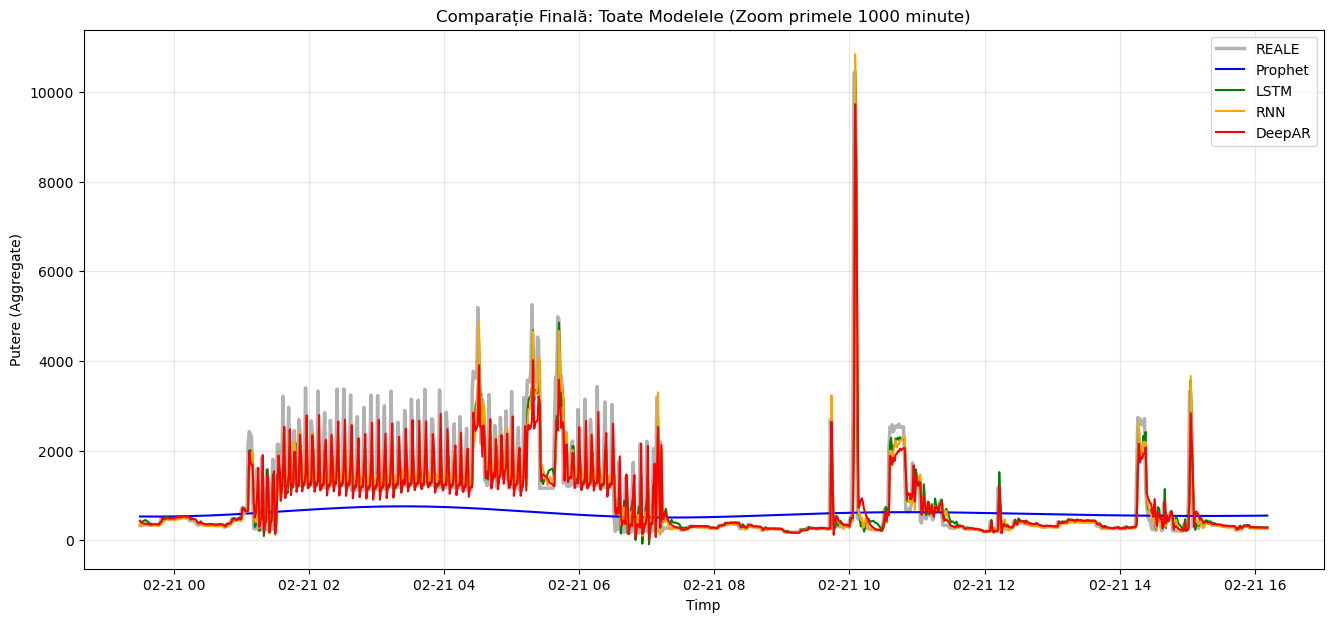

In [11]:
# --- CELULA 7: FINAL COMPARISON ---

# 1. Calcul Metrici (RMSE)
print("\n=== CLASAMENT PERFORMANȚĂ (RMSE - Mai mic e mai bine) ===")
for model_name, pred in rezultate_finale.items():
    # Ne asigurăm că lungimile coincid (uneori Prophet poate avea 1 punct diferență din cauza indexului)
    min_len = min(len(test_data), len(pred))
    rmse = np.sqrt(mean_squared_error(test_data['Aggregate'].iloc[:min_len], pred[:min_len]))
    metrici_finale[model_name] = rmse

# Afișare sortată
for nume, scor in sorted(metrici_finale.items(), key=lambda x: x[1]):
    print(f"🔹 {nume}: {scor:.2f}")

# 2. GRAFIC CENTRALIZAT
plt.figure(figsize=(16, 7))

# Setăm un zoom (de ex. primele 1000 minute din test) pentru a vedea detaliile
ZOOM = 1000 
test_zoom = test_data.index[:ZOOM]
val_real = test_data['Aggregate'].values[:ZOOM]

# Plot Date Reale
plt.plot(test_zoom, val_real, label='REALE', color='black', linewidth=2.5, alpha=0.3)

# Plot Modele
colors = {'Prophet': 'blue', 'LSTM': 'green', 'RNN': 'orange', 'DeepAR': 'red'}

for nume, pred in rezultate_finale.items():
    plt.plot(test_zoom, pred[:ZOOM], label=f'{nume}', color=colors.get(nume, 'gray'), linewidth=1.5)

plt.title(f'Comparație Finală: Toate Modelele (Zoom primele {ZOOM} minute)')
plt.xlabel('Timp')
plt.ylabel('Putere (Aggregate)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()